In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm
import torch.nn.functional as F

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters
num_epochs = 10
batch_size = 64
learning_rate = 0.002

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ! unzip /content/drive/MyDrive/dataset_256X256.zip

In [ ]:
# Define the path to your dataset folder
dataset_path = '/content/dataset_256X256'

In [ ]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])

In [ ]:
# Load the training dataset
train_dataset = ImageFolder(root=dataset_path + "/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load the testing dataset
test_dataset = ImageFolder(root=dataset_path + "/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

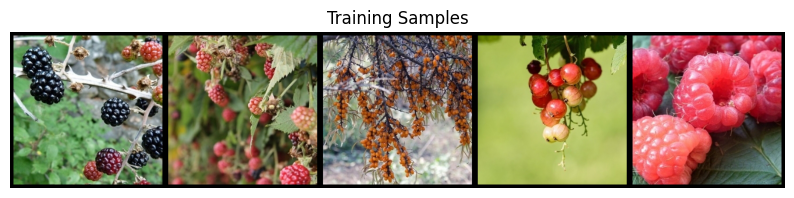

In [18]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a few samples from the training dataset
num_samples = 5
samples = []
for i in range(num_samples):
    sample, label = train_dataset[i]
    samples.append((sample, label))

# Create a grid of images
grid = vutils.make_grid([sample for sample, _ in samples], nrow=num_samples, padding=2, normalize=True)

# Plot the grid of images
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Training Samples")
plt.show()

In [19]:
# import random
# import matplotlib.pyplot as plt
# import torchvision.utils as vutils

# # Define the number of samples to visualize for each class
# num_samples_per_class = 5

# # Create a list to store the selected samples
# selected_samples = []

# # Loop through each class
# for class_idx, class_name in enumerate(train_dataset.classes):
#     # Get samples with the current class
#     class_samples = [sample for sample, label in train_dataset if label == class_idx]
    
#     # Select a random subset of samples
#     random_samples = random.sample(class_samples, num_samples_per_class)
    
#     # Add the selected samples to the list
#     selected_samples.extend(random_samples)

# # Create a grid of images
# grid = vutils.make_grid(selected_samples, nrow=num_samples_per_class, padding=2, normalize=True)

# # Plot the grid of images
# plt.figure(figsize=(10, 5))
# plt.imshow(grid.permute(1, 2, 0))
# plt.axis("off")
# plt.title("Training Samples by Class")
# plt.show()

In [20]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [21]:
model = ResNet().to(device)

In [22]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
for epoch in tqdm(range(num_epochs)):
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    
    # Set the model to train mode
    model.train()
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate training loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Calculate average training loss and accuracy
    train_loss /= total_train
    train_accuracy = train_correct / total_train
    
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Calculate average validation loss and accuracy
    val_loss /= total_val
    val_accuracy = val_correct / total_val
    
    # Print or log the training and validation loss and accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}  Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}  Val Accuracy: {val_accuracy:.4f}")
    print()
    
# Save the trained model
torch.save(model.state_dict(), 'resnet_model.pth')

  4%|▍         | 3/75 [00:54<21:57, 18.30s/it]

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))